<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Random Forest (RF) Modeling 
</p>

In [8]:
# Libraries for data manipulation and visualization
import numpy as np                               # For numerical operations
import pandas as pd                              # For data manipulation
import matplotlib.pyplot as plt                  # For plotting
import seaborn as sns                            # For advanced data visualization

# Libraries for model building and evaluation
from sklearn.ensemble import RandomForestRegressor  # For Random Forest Regression
from sklearn.metrics import (                   # For model evaluation metrics
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error, 
    median_absolute_error
)
from sklearn.model_selection import KFold, train_test_split  # For cross-validation and splitting data

# Set seed for reproducibility
np.random.seed(50)

In [9]:
# Define the path to the dataset
dataset_path = '../../all_data_files/cleaned_dataset_per_device.csv'

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print("\nDataset loaded successfully.\n")
except FileNotFoundError:
    print(f"File not found at the specified path: {dataset_path}")
    import sys
    sys.exit()


Dataset loaded successfully.



In [4]:
# Define feature columns and target
feature_columns = [
    'distance', 'frequency', 'c_walls', 'w_walls', 
    'co2', 'humidity', 'pm25', 'pressure', 
    'temperature', 'snr'
]
target_column = 'exp_pl'

# Verify that all required columns exist
missing_columns = set(feature_columns + [target_column]) - set(df.columns)
if missing_columns:
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Extract features and target
all_features = df[feature_columns].values
PL_all = df[target_column].values

# Perform train-test split (80-20 split)
X_train_all, X_test_all, PL_train_all, PL_test_all = train_test_split(
    all_features, PL_all, test_size=0.2, random_state=50
)

print("\nTrain-test split completed.\n")


Train-test split completed.



In [5]:
# Define Random Forest model
def create_rf_model():
    """Creates a Random Forest model with OOB enabled."""
    return RandomForestRegressor(
        n_estimators=200,  
        criterion='squared_error',
        #criterion='absolute_error',
        max_depth=2,      
        max_features='log2',
        random_state=50,  
        n_jobs=-1,       
        min_samples_split=10, 
        min_samples_leaf=4, 
        min_impurity_decrease=0.01,
        bootstrap=True,      
        oob_score=True 
    )

# Instantiate the model
rf_model = create_rf_model()

# Train the model
print("\nTraining Random Forest model...")
rf_model.fit(X_train_all, PL_train_all)
print("\nTraining Completed! \n")

# Retrieve OOB score
oob_score = rf_model.oob_score_
print(f"Random Forest model training completed with OOB Score: {oob_score:.4f} \n")


Training Random Forest model...

Training Completed! 

Random Forest model training completed with OOB Score: 0.7259 



In [6]:
# Evaluate the model on training and test data
PL_train_pred = rf_model.predict(X_train_all)
PL_test_pred = rf_model.predict(X_test_all)

# Calculate metrics
train_mse = mean_squared_error(PL_train_all, PL_train_pred)
test_mse = mean_squared_error(PL_test_all, PL_test_pred)
train_r2 = r2_score(PL_train_all, PL_train_pred)
test_r2 = r2_score(PL_test_all, PL_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(PL_test_all, PL_test_pred)
test_median_ae = median_absolute_error(PL_test_all, PL_test_pred)

# Create a results DataFrame
results = pd.DataFrame({
    'Metric': ['Training Loss (MSE)', 'Test Loss (MSE)', 'Test RMSE', 'R² Score', 
               'Test MAPE (%)', 'Test Median AE'],
    'Value': [train_mse, test_mse, test_rmse, test_r2, test_mape * 100, test_median_ae]
})

print("\nModel Evaluation Metrics:")
display(results)


Model Evaluation Metrics:


,Metric,Value
0,Training Loss (MSE),99.316609
1,Test Loss (MSE),99.069266
2,Test RMSE,9.953355
3,R² Score,0.726973
4,Test MAPE (%),8.402906
5,Test Median AE,5.671852


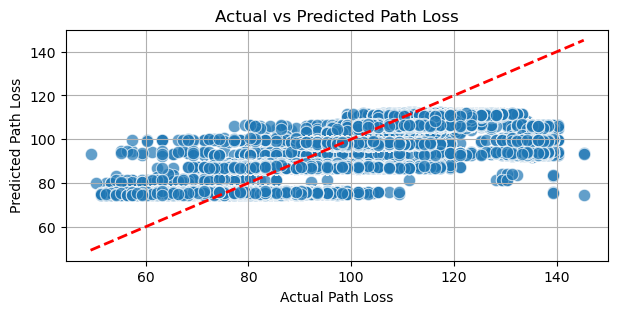

In [7]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(7, 3))
sns.scatterplot(x=PL_test_all, y=PL_test_pred, alpha=0.7, edgecolor='w', s=80)
plt.plot([PL_test_all.min(), PL_test_all.max()], [PL_test_all.min(), PL_test_all.max()], 'r--', lw=2)
plt.xlabel('Actual Path Loss')
plt.ylabel('Predicted Path Loss')
plt.title('Actual vs Predicted Path Loss')
plt.grid(True)
plt.show()

In [ ]:
# Cell 7: Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
fold = 1

for train_idx, val_idx in kf.split(X_train_all):
    print(f"\nTraining fold {fold}...")

    # Split the data for the current fold
    X_train_fold, X_val_fold = X_train_all[train_idx], X_train_all[val_idx]
    PL_train_fold, PL_val_fold = PL_train_all[train_idx], PL_train_all[val_idx]

    # Create and train a new Random Forest model
    rf_model_cv = create_rf_model()
    rf_model_cv.fit(X_train_fold, PL_train_fold)

    # Predict and evaluate on validation set
    PL_val_pred = rf_model_cv.predict(X_val_fold)
    val_mse = mean_squared_error(PL_val_fold, PL_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(PL_val_fold, PL_val_pred)
    val_mape = mean_absolute_percentage_error(PL_val_fold, PL_val_pred)
    val_median_ae = median_absolute_error(PL_val_fold, PL_val_pred)

    # Append metrics
    cv_results.append({
        'Fold': fold,
        'Validation Loss (MSE)': round(val_mse, 4),
        'Validation RMSE': round(val_rmse, 4),
        'R² Score': round(val_r2, 4),
        'Validation MAPE (%)': round(val_mape * 100, 2),
        'Validation Median AE': round(val_median_ae, 4)
    })

    print(f"Fold {fold} - MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}, MAPE: {val_mape*100:.2f}%, Median AE: {val_median_ae:.4f}")
    fold += 1

# Create a DataFrame from CV results
cv_results_df = pd.DataFrame(cv_results)

# Display cross-validation results
print("\nK-Fold Cross-Validation Results:")
display(cv_results_df)

# Summary statistics
cv_summary = cv_results_df.agg(['mean', 'std']).round(4).reset_index()
cv_summary.rename(columns={'index': 'Metric'}, inplace=True)

# Transposing the summary
cv_summary_transposed = cv_summary.set_index('Metric').T

print("\nCross-Validation Summary:")
display(cv_summary_transposed)


Training fold 1...
